In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
# List of folders containing audio + local REFERENCE.csv
folders = ["training-a", "training-b", "training-c", "training-d", "training-e", "training-f"]

# output image category
label_map = {-1: "normal", 1: "abnormal"}

output_dir = "spectrogram_dataset"
os.makedirs(output_dir, exist_ok=True)

for folder in folders:
    print(f"Processing folder: {folder}")
    
    # Read the local REFERENCE.csv
    ref_path = os.path.join(folder, "REFERENCE.csv")
    labels = pd.read_csv(ref_path, header=None, names=["id", "label"])
    
    # Iterate over all .wav files in the folder
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            audio_id = file[:-4]  # remove .wav extension
            # Get the label for this audio
            label_row = labels[labels["id"] == audio_id]
            if label_row.empty:
                continue  # skip if label not found
            label = label_row["label"].values[0]  # This will be 1 or -1
            label_name = label_map[label]          # Convert to "normal" or "abnormal"

            # Create label folder
            label_folder = os.path.join(output_dir, label_name)
            os.makedirs(label_folder, exist_ok=True)

            # Load audio
            audio_path = os.path.join(folder, file)
            y, sr = librosa.load(audio_path, sr=2000)

            # Convert to Mel spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)

            # Plot and save spectrogram
            plt.figure(figsize=(3, 3))
            librosa.display.specshow(S_dB, sr=sr, cmap='magma')
            plt.axis('off')
            out_path = os.path.join(label_folder, audio_id + ".png")
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
            plt.close()

Processing folder: training-a
Processing folder: training-b
Processing folder: training-c
Processing folder: training-d
Processing folder: training-e
Processing folder: training-f


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# This generator will normalize pixel values and create training/validation split with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

In [18]:
train_generator = datagen.flow_from_directory(
    "spectrogram_dataset",   # Path to dataset folder
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary',     # Binary classification (normal vs abnormal)
    subset='training'        # Training split
)

Found 2269 images belonging to 2 classes.


In [19]:
val_generator = datagen.flow_from_directory(
    "spectrogram_dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'      # Validation split
)

Found 971 images belonging to 2 classes.


In [20]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')   # Binary output
])

d:\ACC-HPC\files\AI\project\heartbeat\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,549,057 (24.98 MB)

 Trainable params: 6,549,057 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import tensorflow as tf
with tf.device('/CPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10
    )

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7942 - loss: 0.4749 - val_accuracy: 0.6859 - val_loss: 0.5209
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 592ms/step - accuracy: 0.8400 - loss: 0.3448 - val_accuracy: 0.6416 - val_loss: 0.5850
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 609ms/step - accuracy: 0.8775 - loss: 0.2817 - val_accuracy: 0.5819 - val_loss: 0.7508
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 587ms/step - accuracy: 0.8867 - loss: 0.2704 - val_accuracy: 0.4634 - val_loss: 0.8388
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 618ms/step - accuracy: 0.9000 - loss: 0.2388 - val_accuracy: 0.4573 - val_loss: 1.0439
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 591ms/step - accuracy: 0.9097 - loss: 0.2238 - val_accuracy: 0.4511 - val_loss: 1.0656
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.9185 - loss: 0.2114 - val_accuracy: 0.4717 - val_loss: 1.0611
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.9132 - loss: 0.2133 - val_accurac

In [34]:
loss, accuracy = model.evaluate(train_generator)
print("train Accuracy:", accuracy)
print("train Loss:", loss)

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9352 - loss: 0.1621
train Accuracy: 0.9352137446403503
train Loss: 0.1620834618806839


In [24]:
loss, accuracy = model.evaluate(val_generator)
print("Validation Accuracy:", accuracy)
print("Validation Loss:", loss)

31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.4459 - loss: 1.3198
Validation Accuracy: 0.4459320306777954
Validation Loss: 1.3198423385620117


In [25]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}


In [26]:
print("Normal:", len(os.listdir("spectrogram_dataset/normal")))
print("Abnormal:", len(os.listdir("spectrogram_dataset/abnormal")))

Normal: 2575
Abnormal: 665


In [27]:
print(train_generator.samples)
print(val_generator.samples)

2269
971


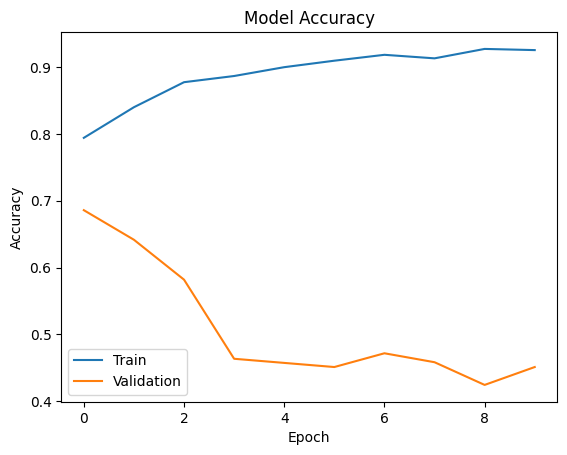

In [28]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

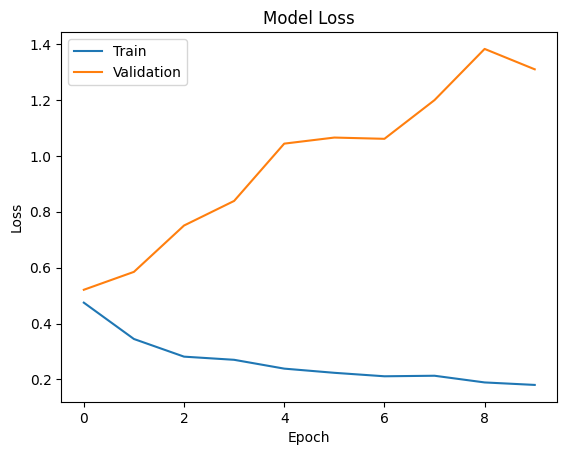

In [29]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [30]:
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step


In [31]:
from sklearn.metrics import confusion_matrix

y_true = val_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

[[130  69]
 [481 291]]


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Abnormal']))


              precision    recall  f1-score   support

      Normal       0.21      0.65      0.32       199
    Abnormal       0.81      0.38      0.51       772

    accuracy                           0.43       971
   macro avg       0.51      0.52      0.42       971
weighted avg       0.69      0.43      0.47       971

